In [ ]:
# =============================================================
# TDCSFOG PREPROCESSING SCRIPT (WITH STEP-BY-STEP COMMENTS)
# =============================================================
# This script automatically processes ALL CSV/XLS/XLSX/TXT files
# inside the tdcsfog folder. No manual naming required.
#
# Steps included:
#   STEP 1 – Import libraries
#   STEP 2 – Helper functions
#   STEP 3 – Label extraction
#   STEP 4 – Sliding window creation
#   STEP 5 – File preprocessing
#   STEP 6 – Process entire folder
#   STEP 7 – Save final dataset
# =============================================================


In [ ]:
# =============================================================
# STEP 1 — Import required libraries
# =============================================================
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

In [ ]:
# =============================================================
# STEP 2 — Helper function: smooth signals
# =============================================================
def smooth_signal(df, window=5):
    if window <= 1:
        return df
    return df.rolling(window=window, center=True, min_periods=1).mean()

In [ ]:
# =============================================================
# STEP 3 — Helper function: determine window label
# =============================================================
def get_window_label(window):
    # Count how many times each event appears
    sh = window['StartHesitation'].sum()
    tr = window['Turn'].sum()
    wk = window['Walking'].sum()

    # If all zero → no event
    if sh == 0 and tr == 0 and wk == 0:
        return 0

    # Priority: StartHesitation = 1, Turn = 2, Walking = 3
    max_event = max(sh, tr, wk)
    if sh == max_event:
        return 1
    if tr == max_event:
        return 2
    return 3

In [ ]:
# =============================================================
# STEP 4 — Create sliding windows
# =============================================================
def make_windows(df, window_size, stride):
    X = []
    y = []
    starts = []

    for start in range(0, len(df) - window_size + 1, stride):
        end = start + window_size
        window = df.iloc[start:end]

        # Extract accelerometer channels
        acc = window[['AccV', 'AccML', 'AccAP']].values

        # Assign label
        label = get_window_label(window)

        X.append(acc)
        y.append(label)
        starts.append(start)

    return np.array(X), np.array(y), np.array(starts)


In [ ]:
# =============================================================
# STEP 5 — Process a single file
# =============================================================
def process_single_file(filepath, fs=128, window_sec=2, stride_sec=0.5, smooth_win=5):
    print(f"Processing: {os.path.basename(filepath)}")

    ext = filepath.split('.')[-1].lower()

    # Read file depending on type
    if ext == 'csv':
        df = pd.read_csv(filepath)
    elif ext in ['xls', 'xlsx']:
        df = pd.read_excel(filepath)
    elif ext == 'txt':
        df = pd.read_csv(filepath, sep='	')
    else:
        print("Unsupported file type → skipping")
        return None

    # Ensure required columns exist
    for col in ['AccV','AccML','AccAP']:
        if col not in df.columns:
            print(f"Missing {col} → skipping file")
            return None

    # Create label columns if missing
    for col in ['StartHesitation','Turn','Walking']:
        if col not in df.columns:
            df[col] = 0

    # Drop NaN rows
    df = df.dropna().reset_index(drop=True)

    # Apply smoothing
    df[['AccV','AccML','AccAP']] = smooth_signal(df[['AccV','AccML','AccAP']], smooth_win)

    # Normalize per file
    scaler = StandardScaler()
    df[['AccV','AccML','AccAP']] = scaler.fit_transform(df[['AccV','AccML','AccAP']])

    # Window size in samples
    window_size = int(window_sec * fs)
    stride = int(stride_sec * fs)

    # Generate windows
    return make_windows(df, window_size, stride)

In [ ]:
# =============================================================
# STEP 6 — Process the entire tdcsfog folder
# =============================================================
def process_tdcsfog_folder(folder, save_path='tdcsfog_processed.npz'):
    X_all = []
    y_all = []
    file_ids = []
    start_idx_all = []

    # Find all files
    for root, dirs, files in os.walk(folder):
        for f in files:
            if f.endswith(('.csv','.txt','.xls','.xlsx')):
                full_path = os.path.join(root, f)

                # Process file
                result = process_single_file(full_path)
                if result is None:
                    continue

                X, y, starts = result

                # Collect
                X_all.append(X)
                y_all.append(y)
                start_idx_all.append(starts)
                file_ids.append(np.full(len(y), f))

    # Combine all
    X_all = np.vstack(X_all)
    y_all = np.hstack(y_all)
    file_ids = np.hstack(file_ids)
    start_idx_all = np.hstack(start_idx_all)

    # Save
    np.savez_compressed(save_path, X=X_all, y=y_all, file_ids=file_ids, start_indices=start_idx_all)

    print(f"Saved processed dataset → {save_path}")
    return X_all, y_all, file_ids, start_idx_all


In [ ]:
import os

# 1️⃣ Set tdcsfog folder path
folder_path = '/content/Project_FYP/Project FYP/tdcsfog'

# 2️⃣ Verify folder and files
if not os.path.exists(folder_path):
    raise FileNotFoundError(f"tdcsfog folder not found at {folder_path}")

print("Files found in tdcsfog folder:")
for f in os.listdir(folder_path):
    print(" -", f)

# 3️⃣ Process tdcsfog folder (your original function)
process_tdcsfog_folder(folder_path, save_path='/content/tdcsfog_processed.npz')


Files found in tdcsfog folder:
 - 87299da5f6.csv
 - 2e3b57b4e8.csv
 - 382f4dc088.csv
 - 9dbe8f59ae.csv
 - e8f45c11b3.csv
 - 9d02d58fa7.csv
 - be8fdfa712.csv
 - 8fc05fabee.csv
 - dbda844446.csv
 - b109fba6f4.csv
 - 6e05dd955f.csv
 - 8c2be63bd3.csv
 - 6b6644132d.csv
 - 84097a9565.csv
 - 8809a076c6.csv
 - 67c9018b72.csv
 - e7530a59ae.csv
 - 4c2efc2da7.csv
 - 9ee7d24df1.csv
 - faf4a914fc.csv
 - 88834994d3.csv
 - 1254c50add.csv
 - 47084c5065.csv
 - 6dc32464d9.csv
 - b0be1a5d4f.csv
 - 16c577bb75.csv
 - 4d89a40d66.csv
 - 2d481ad987.csv
 - 0c7b7078a3.csv
 - a1396ddf69.csv
 - 08e8e06116.csv
 - fbbdaf477b.csv
 - e3406f028b.csv
 - 38ca933665.csv
 - 616371ed4d.csv
 - 758ddee3f7.csv
 - 9d161e0027.csv
 - b83ea5ec79.csv
 - 257c266332.csv
 - 2365c918c9.csv
 - ecfa9e6b7b.csv
 - fd5300c038.csv
 - 3656b7f3ba.csv
 - 57c92c24bd.csv
 - 1e45dd8eab.csv
 - eac8e044ca.csv
 - b787e23929.csv
 - c3ac51e605.csv
 - 9909a2f249.csv
 - 9444579a07.csv
 - 8b00ba8eff.csv
 - c296f8bc53.csv
 - b422b8dabc.csv
 - 8b7447aec8.c

(array([[[-0.14645222,  0.7369783 , -1.25916191],
         [-0.14985098,  0.73864571, -1.26883522],
         [-0.15189863,  0.74039309, -1.27898366],
         ...,
         [-0.24297998,  0.67851707,  2.04575268],
         [-0.35162608,  0.76697149,  2.05252459],
         [-0.48169509,  0.78839357,  2.1407228 ]],
 
        [[-0.15886377,  0.73698227, -1.30327112],
         [-0.15955533,  0.73739498, -1.30201667],
         [-0.16055065,  0.73636116, -1.29981663],
         ...,
         [ 2.19198267,  0.18509888, -0.15549226],
         [ 2.26445545,  0.12443503, -0.2121943 ],
         [ 2.3116617 ,  0.03389066, -0.26493975]],
 
        [[-0.16138023,  0.73551314, -1.30545361],
         [-0.16061044,  0.73404531, -1.30202643],
         [-0.15946448,  0.73145968, -1.29890874],
         ...,
         [-0.34918256,  0.69715089, -0.28848415],
         [-0.44456156,  0.64042561, -0.45964921],
         [-0.5847053 ,  0.56978186, -0.55760452]],
 
        ...,
 
        [[ 1.80915856, -2.33076905

Arrays in file: ['X', 'y', 'file_ids', 'start_indices']
X shape: (107447, 256, 3)
y shape: (107447,)

NaNs in X: False
Infs in X: False
NaNs in y: False
Infs in y: False

X min: -51.86546102169552
X max: 16.549796767883795
X mean: 0.014705228862453195
X std: 0.9889145675883595

Label distribution: {np.int64(0): np.int64(69037), np.int64(1): np.int64(5111), np.int64(2): np.int64(29686), np.int64(3): np.int64(3613)}

First sample X:
 [[-0.14645222  0.7369783  -1.25916191]
 [-0.14985098  0.73864571 -1.26883522]
 [-0.15189863  0.74039309 -1.27898366]
 [-0.15616489  0.74314374 -1.29478086]
 [-0.15982754  0.7446404  -1.30752786]
 [-0.16125653  0.74467289 -1.31404278]
 [-0.16100907  0.74342889 -1.31409513]
 [-0.16072925  0.74183618 -1.30668733]
 [-0.15982326  0.73976589 -1.29900918]
 [-0.15808771  0.73892419 -1.29345119]
 [-0.15737217  0.73890972 -1.29158995]
 [-0.15766034  0.73860835 -1.29187314]
 [-0.15695291  0.7352009  -1.29499989]
 [-0.15634608  0.73393253 -1.29521612]
 [-0.1577676   0.7

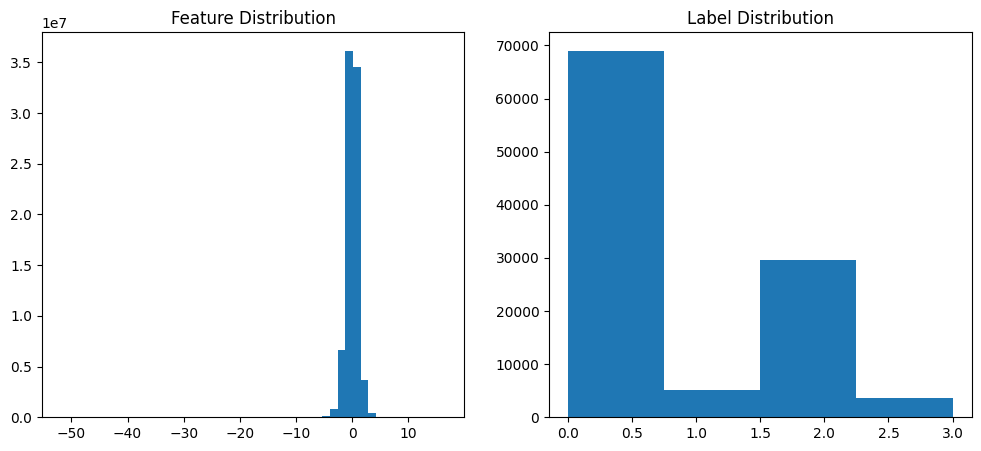


✅ Dataset looks clean (no NaNs or infinities).


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Load your dataset
file_path = 'tdcsfog_processed.npz'  # change if your file name/path is different
data = np.load(file_path)

# --- 1. Check array names and shapes ---
print("Arrays in file:", list(data.keys()))
print("X shape:", data['X'].shape)
print("y shape:", data['y'].shape)

# --- 2. Check for NaNs or Infs ---
nan_X = np.isnan(data['X']).any()
inf_X = np.isinf(data['X']).any()
nan_y = np.isnan(data['y']).any()
inf_y = np.isinf(data['y']).any()
print("\nNaNs in X:", nan_X)
print("Infs in X:", inf_X)
print("NaNs in y:", nan_y)
print("Infs in y:", inf_y)

# --- 3. Check value stats for X ---
print("\nX min:", data['X'].min())
print("X max:", data['X'].max())
print("X mean:", data['X'].mean())
print("X std:", data['X'].std())

# --- 4. Check label distribution ---
unique, counts = np.unique(data['y'], return_counts=True)
label_distribution = dict(zip(unique, counts))
print("\nLabel distribution:", label_distribution)

# --- 5. Quick preview ---
print("\nFirst sample X:\n", data['X'][0])
print("First label y:", data['y'][0])

# --- 6. Optional: plot histograms ---
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.hist(data['X'].flatten(), bins=50)
plt.title("Feature Distribution")
plt.subplot(1,2,2)
plt.hist(data['y'], bins=len(unique))
plt.title("Label Distribution")
plt.show()

# --- 7. Summary check ---
if not (nan_X or inf_X or nan_y or inf_y):
    print("\n Dataset looks clean (no NaNs or infinities).")
else:
    print("\n Dataset has missing or infinite values. You need to clean it first.")
